In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d

sys.path.insert(0,'/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')

from Signal_processing_utils import dx_dt, get_activity_interval, bilateral_filter_smoothing

In [3]:
%load_ext autoreload
%autoreload 1

%aimport Signal_processing_utils
# %matplotlib widget
%matplotlib inline

In [4]:
# input block
motion_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_june18_short/MySlate_14_iPhone_raw.csv"
calibration_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_june18_short/MySlate_14_iPhone_cal.csv"

# motion_data_path = "C:/Users/evan1/Documents/staggered_face/data/live_link_data/LiveLinkFace_20220926_MySlate_7_Evans_Iphone/MySlate_7_Evans_Iphone.csv"
mesh_to_name_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json"
name_to_mesh_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json"
out_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_june18_short/for_maya_json.json"
mode = "acceleration"

# Obtain the predicted blendshapes

In [5]:
def load_apple_motion(motion_data_path = "", recordingfps=30, calibration_data_path=""):
    name_to_mesh = {}
    mesh_to_name = {}
    # load model
    with open("/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json") as f:
        mesh_to_name = json.load(f)
    with open("/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json") as f:
        name_to_mesh = json.load(f)
    # load data from file
    columns = []
    raw_cal_data = []
    cal_data = []
    times = []
    with open(calibration_data_path) as f:
        labels = f.readline()
        columns = labels.split(",")
        columns = columns[2:]
        raw_cal_data = f.readlines()
    for i in range(0, len(raw_cal_data)):
        frame_time = raw_cal_data[i].split(",")[0]
        frame_time_list = frame_time.split(":")
        frame_hour, frame_minute, frame_second, frame_frame = frame_time_list
        frame_hour = float(frame_hour)
        frame_minute = float(frame_minute)
        frame_second = float(frame_second)
        frame_frame = float(frame_frame)
        frame_time = frame_frame/recordingfps + frame_second + frame_minute * 60 + frame_hour * 3600        
        frame_cal_data = raw_cal_data[i].split(",")
        if len(frame_cal_data) > 20:
            times.append(frame_time)
            numerical_values = [float(x) for x in frame_cal_data[2:]]
            cal_data.append(numerical_values)
    start_time = times[0]
    for i in range(0, len(times)):
        times[i] = times[i] - start_time
    cal_data = np.array(cal_data)
    values_dict = {}
    for i in range(0, len(columns)):
        values_dict[columns[i]] = cal_data[:, i]
    return times, values_dict

times, values_dict = load_apple_motion(motion_data_path, 30, calibration_data_path)
all_AU = []
labels = list(values_dict.keys())
for i in range(0, len(labels[:-10])):
    all_AU.append(labels[i])

# Detecting onsets of motions

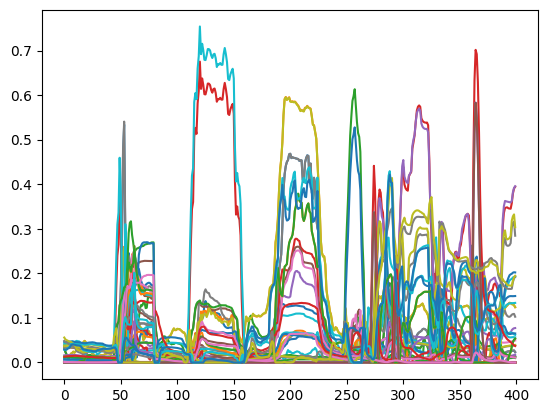

In [6]:
onset_threshold = 0.07

plt.clf()
onset_curve_dict = {}
for i in range(0, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    # plot the curves to view
    au_i_curve = au_i_curve[0:400]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label=au_i)
    # find onset
    au_i_vel_curve = dx_dt(filtered_au_i_curve, dt=1/30.0, method=2)
    au_i_acc_curve = dx_dt(au_i_vel_curve, dt=1/30.0, method=2)
    onsets = np.zeros(au_i_vel_curve.shape)
    ts = list(range(0, au_i_vel_curve.shape[0]))
    for t in ts:
        if au_i_vel_curve[t] >= onset_threshold:
            onsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_activity = get_activity_interval(onsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    activation = [x[0] for x in action_unit_activity]
    # plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="motion onset")
    peak = [x[1] for x in action_unit_activity]
    # plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="motion peak")
    # if i == 10:
    #     break
# plt.legend()
plt.show()


# Find the closest neighbour for each onset curve

In [7]:
def generate_heatmap(distance_matrix, row_labels, col_labels):
    # Normalize the distance matrix to [0, 1]
    normalized_matrix = distance_matrix

    # Create the heatmap visualization using imshow
    plt.imshow(normalized_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Distance')

    # Set the tick labels for the x-axis and y-axis
    plt.xticks(np.arange(len(col_labels)), col_labels)
    plt.yticks(np.arange(len(row_labels)), row_labels)

    # Rotate the x-axis tick labels for better visibility
    plt.xticks(rotation=90)

    # Set axis labels
    plt.xlabel('Attribute')
    plt.ylabel('Attribute')

    # Show the plot
    plt.show()

# get all the curves
all_onset_curves = []
for au_i in all_AU:
    all_onset_curves.append(np.expand_dims(onset_curve_dict[au_i], axis=0))
all_onset_curves = np.concatenate(all_onset_curves, axis=0)

all_motion_curves = []
for au_i in all_AU:
    all_motion_curves.append(np.expand_dims(values_dict[au_i], axis=0))
all_motion_curves = np.concatenate(all_motion_curves, axis=0)


## compute pairwise distance (onset)

### With processed onset curve

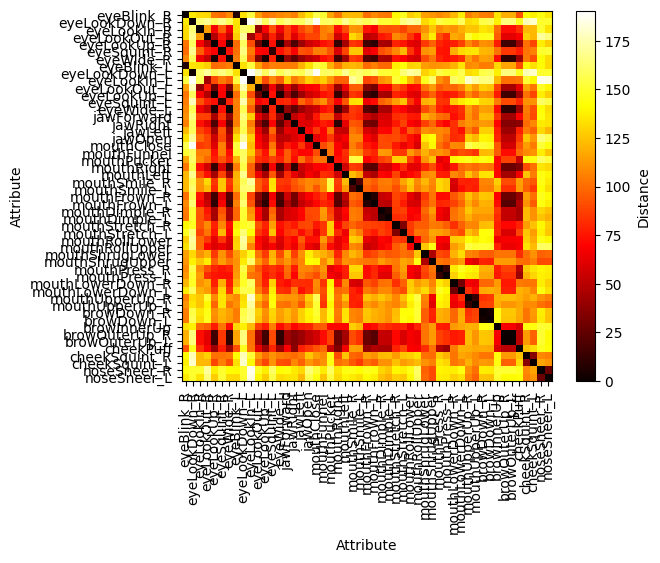

In [309]:
input_matrix = all_onset_curves
output_matrix = np.zeros([input_matrix.shape[0], input_matrix.shape[0]])
for i in range(0, input_matrix.shape[0]):
    ith_curve = input_matrix[i:i+1]
    # here I will use the MSE distance
    distance = np.sum(np.square(input_matrix - ith_curve), axis=1)
    output_matrix[i, :] = distance
plt.clf()
generate_heatmap(output_matrix, all_AU, all_AU)

### With raw motion curve

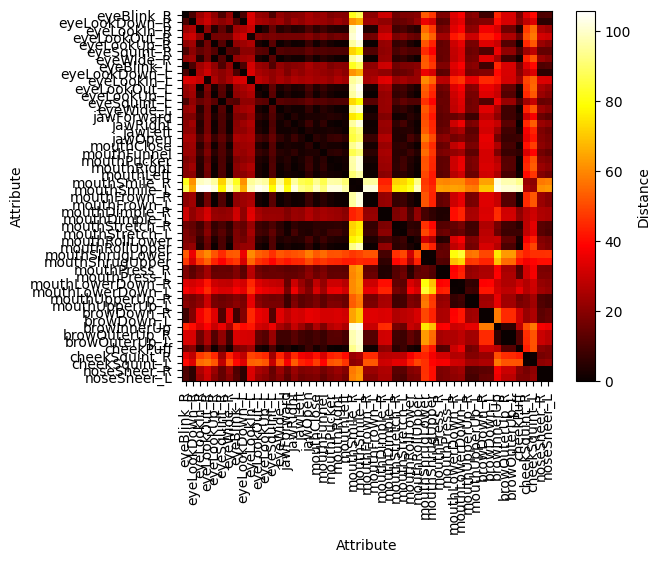

In [310]:
input_matrix = all_motion_curves
output_matrix = np.zeros([all_motion_curves.shape[0], all_motion_curves.shape[0]])
for i in range(0, all_motion_curves.shape[0]):
    ith_curve = all_motion_curves[i:i+1]
    # here I will use the MSE distance
    distance = np.sum(np.square(all_motion_curves - ith_curve), axis=1)
    output_matrix[i, :] = distance
plt.clf()
generate_heatmap(output_matrix, all_AU, all_AU)

### with DTW

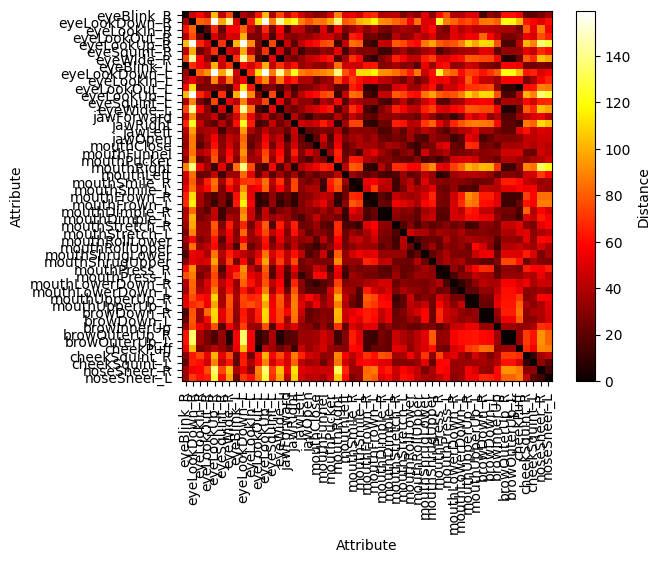

In [311]:
input_matrix = all_onset_curves
dtw_output_matrix = np.zeros([input_matrix.shape[0], input_matrix.shape[0]])
for i in range(0, input_matrix.shape[0]):
    # here I will use the DTW distance
    for j in range(0, input_matrix.shape[0]):
        dist, path = fastdtw(input_matrix[i], input_matrix[j], dist=2)
        dtw_output_matrix[i, j] = dist
plt.clf()
generate_heatmap(dtw_output_matrix, all_AU, all_AU)

In [312]:
from sklearn.neighbors import NearestNeighbors
brs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(all_onset_curves)
distances, indices = brs.kneighbors(all_motion_curves)

# compute pairwise distance

ValueError: X has 873 features, but NearestNeighbors is expecting 400 features as input.

In [ ]:
for i in range(0, len(all_onset_curves)):
    print(all_AU[i])
    neighbours = ""
    for k in range(0, len(indices[i])):
        neighbours+= all_AU[indices[i][k]] + ": {} \n".format(distances[i][k])
    print(neighbours)

eyeBlink_R
eyeBlink_R: 0.0 
eyeBlink_L: 2.6457513110645907 
cheekPuff: 9.643650760992955 
eyeSquint_R: 10.0 
mouthFrown_R: 10.04987562112089 

eyeLookDown_R
eyeLookDown_R: 0.0 
eyeLookDown_L: 1.4142135623730951 
mouthShrugLower: 11.445523142259598 
mouthUpperUp_R: 11.489125293076057 
eyeBlink_L: 11.61895003862225 

eyeLookIn_R
eyeLookIn_R: 0.0 
eyeLookOut_L: 6.244997998398398 
eyeWide_R: 8.12403840463596 
eyeWide_L: 8.12403840463596 
eyeLookUp_R: 8.18535277187245 

eyeLookOut_R
eyeLookOut_R: 0.0 
eyeLookIn_L: 6.557438524302 
eyeLookUp_R: 6.928203230275509 
eyeLookUp_L: 6.928203230275509 
mouthFrown_R: 7.0710678118654755 

eyeLookUp_R
eyeLookUp_L: 0.0 
eyeLookUp_R: 0.0 
eyeWide_R: 2.23606797749979 
eyeWide_L: 2.23606797749979 
mouthFrown_L: 3.1622776601683795 

eyeSquint_R
eyeSquint_R: 0.0 
eyeSquint_L: 3.3166247903554 
mouthRight: 7.681145747868608 
mouthFrown_R: 7.810249675906654 
mouthRollUpper: 8.06225774829855 

eyeWide_R
eyeWide_R: 0.0 
eyeWide_L: 0.0 
eyeLookUp_L: 2.2360679774997

# find onsets, but limit the search to symmetric components (i.e. ignore assymetries)

## Understand what's symmetrical and what's not

In [8]:
# assymetrical action units
asymmetrical = [] # these have _L or _R behind
# symmetrical
symmetrical_only = []
head_eye = []

# here I will  
sym_AU = []

labels = list(values_dict.keys())
for i in range(0, len(labels[:-10])):
    if len(labels[i].split("_")) == 2:
        if labels[i].split("_")[1] == "L":
            sym_AU.append(labels[i])
    elif labels[i][-4:].lower() == "left":
        sym_AU.append(labels[i])
    else:
        sym_AU.append(labels[i])
for i in range(len(labels)-9, len(labels)):
    head_eye.append(labels[i])

# Identify the Motion Onset

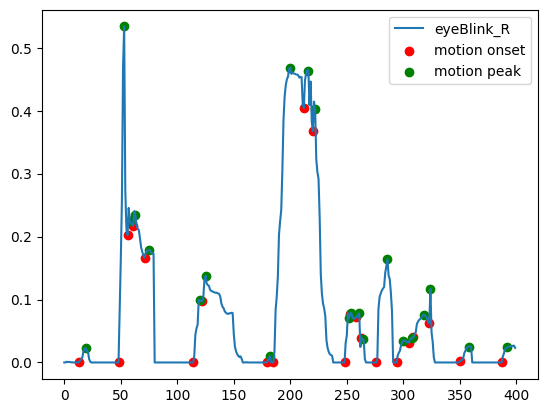

In [9]:
onset_threshold = 0.07

plt.clf()
onset_curve_dict = {}
for i in range(0, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    # plot the curves to view
    au_i_curve = au_i_curve[0:400]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label=au_i)
    # find onset
    au_i_vel_curve = dx_dt(filtered_au_i_curve, dt=1/30.0, method=2)
    au_i_acc_curve = dx_dt(au_i_vel_curve, dt=1/30.0, method=2)
    onsets = np.zeros(au_i_vel_curve.shape)
    ts = list(range(0, au_i_vel_curve.shape[0]))
    for t in ts:
        if au_i_vel_curve[t] >= onset_threshold:
            onsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_activity = get_activity_interval(onsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    activation = [x[0] for x in action_unit_activity]
    plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="motion onset")
    peak = [x[1] for x in action_unit_activity]
    plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="motion peak")
    if i == 0:
        break
plt.legend()
plt.show()


In [315]:
onset_threshold = 0.07
sym_onset_curve_dict = {}
sym_peak_point_dict = {}
plt.clf()
for i in range(0, len(sym_AU)):
    au_i = sym_AU[i]
    au_i_curve = values_dict[au_i]
    # plot the curves to view
    au_i_curve = au_i_curve[0:1000]
    filtered_au_i_curve = au_i_curve
    # plt.plot(filtered_au_i_curve, label=au_i)
    # find onset
    au_i_vel_curve = dx_dt(filtered_au_i_curve, dt=1/30.0, method=2)
    au_i_acc_curve = dx_dt(au_i_vel_curve, dt=1/30.0, method=2)
    onsets = np.zeros(au_i_vel_curve.shape)
    ts = list(range(0, au_i_vel_curve.shape[0]))
    for t in ts:
        if au_i_vel_curve[t] >= onset_threshold:
            onsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_activity = get_activity_interval(onsets, np.array(ts))
    sym_onset_curve_dict[au_i] = onsets
    activation = [x[0] for x in action_unit_activity]
    # plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="onset")
    peak = [x[1] for x in action_unit_activity]
    sym_peak_point_dict[au_i] = peak
#     plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="peak")
#     break
# plt.legend()
# plt.show()
sym_onset_curves = []
for au_i in sym_AU:
    sym_onset_curves.append(np.expand_dims(sym_onset_curve_dict[au_i], axis=0))
sym_onset_curves = np.concatenate(sym_onset_curves, axis=0)
all_peaks = []
peak_arr = np.zeros(sym_onset_curves.shape)
for i in range(0, len(sym_AU)):
    au_i = sym_AU[i]
    all_peaks.append(sym_peak_point_dict[au_i])
    peak_arr[i][sym_peak_point_dict[au_i]] = 1
    peak_arr[i] = gaussian_filter1d(peak_arr[i], 1)
peak_arr_sum = np.sum(peak_arr, axis=0)
    

<Figure size 640x480 with 0 Axes>

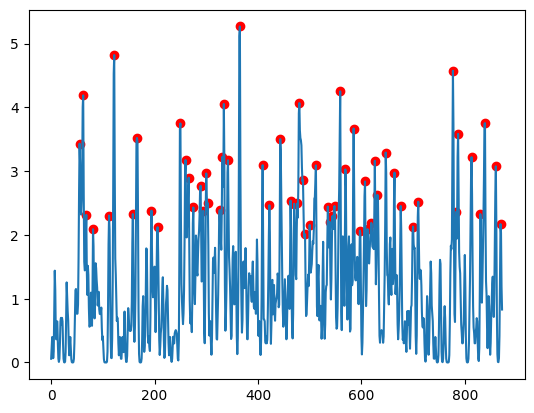

In [316]:
from scipy.signal import argrelextrema

x = np.random.random(12)
thre = 2
# for local maxima
extremes = argrelextrema(peak_arr_sum, np.greater)[0]
extremes_filtered = []
for i in range(0, len(extremes)):
    if peak_arr_sum[extremes[i]] >= thre:
        extremes_filtered.append(extremes[i])
plt.clf()
plt.plot(peak_arr_sum)
plt.scatter(extremes_filtered, peak_arr_sum[extremes_filtered], c="r")
plt.show()
output_json = {"key_frames":[]}
output_json["key_frames"] = [int(x) for x in extremes_filtered]

with open("/Users/evanpan/Desktop/key_frames.json", "w") as f:
    json.dump(output_json, f)

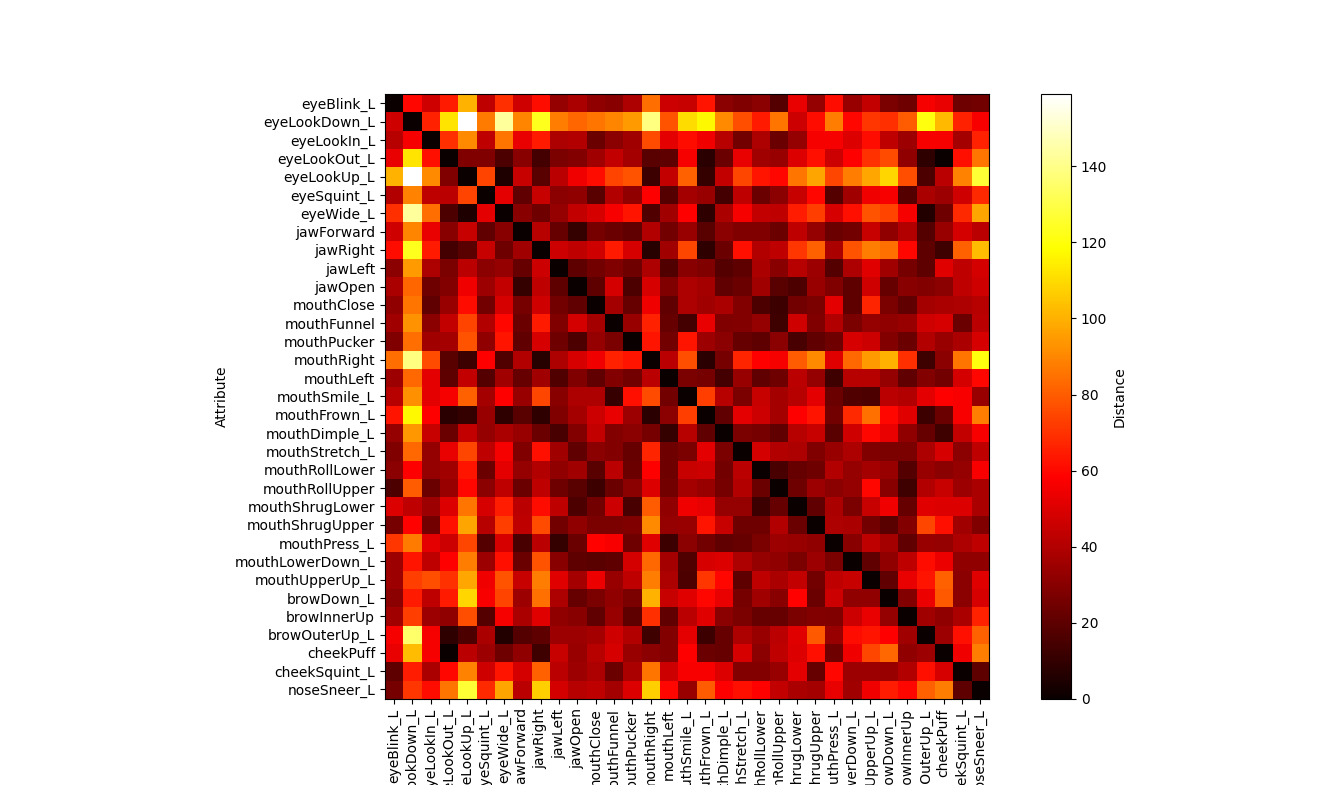

In [189]:
input_matrix = sym_onset_curves
output_matrix = np.zeros([input_matrix.shape[0], input_matrix.shape[0]])
for i in range(0, input_matrix.shape[0]):
    # here I will use the MSE distance
    for j in range(0, input_matrix.shape[0]):
        dist, path = fastdtw(input_matrix[i], input_matrix[j], dist=2)
        output_matrix[i, j] = dist
plt.clf()
generate_heatmap(output_matrix, sym_AU, sym_AU)